In [1]:
import numpy as np
import pandas as pd
import os, csv, re
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join, exists
from collections import Counter
from itertools import groupby
if "results" in os.listdir():
    os.chdir("results")


In [12]:
def read_labels(filename):
    out = None
    with open(filename, "r") as f:
        for line in f:
            arr = np.asarray([int(x) for x in line.split()])
            if out is None:
                out = arr
            else:
                out = np.concatenate((out, arr))
    return out

def read_phones_txt(filename):
    idx_to_phone = {}
    with open(filename, "r") as f:
        for line in f:
            entry = line.split()
            phone = entry[0]
            phone_idx = int(entry[1])
            idx_to_phone[phone_idx] = phone
    return idx_to_phone

def get_unique_combined(pred_phones, lab_phones):
    unique_pred = np.unique(pred_phones)
    unique_lab = np.unique(lab_phones)
    unique_combined = np.asarray(list(set(list(unique_pred) + list(unique_lab))))
    return unique_combined


def plot_conf_matrix(pred_filepath, true_filepath, phones_txt_filepath):
    print("Reading files...")
    pred_lab = read_labels(pred_filepath)
    true_lab = read_labels(true_filepath)
    accuracy = (pred_lab == true_lab).sum() / len(pred_lab)
    print("Accuracy: {0:.3f}".format(accuracy))
    
    idx_to_phone = read_phones_txt(phones_txt_filepath)
    pred_phones = np.asarray([idx_to_phone[x] for x in pred_lab])
    lab_phones = np.asarray([idx_to_phone[x] for x in true_lab])
    unique_combined = get_unique_combined(pred_phones, lab_phones)
    unique_combined.sort()
    
    print("Building confusion matrix...")
    conf = confusion_matrix(lab_phones, pred_phones, labels=unique_combined)
    # Filter zero rows
    nonzero_idx = np.sum(conf, axis=1) > 0
    conf = conf[nonzero_idx]
    ylabs = unique_combined[nonzero_idx]
    
    norm_sum = conf.sum(axis=0)
    norm_sum[norm_sum == 0] = 1
    norm_conf = conf/ norm_sum
    
    plt.figure(figsize=(20,10))
    sns.heatmap(norm_conf, cmap="binary", 
                xticklabels=unique_combined, yticklabels=ylabs)
    plt.xlabel("Predicted phones")
    plt.ylabel("True phones")
    plt.tight_layout()
    plt.savefig("conf_norm.pdf",bbox_inches="tight")
    plt.show() 

In [27]:
conf = confusion_matrix(lab, pred)

In [43]:
611026/1038357

0.5884546451750217

Reading files...
Accuracy: 0.588
Building confusion matrix...


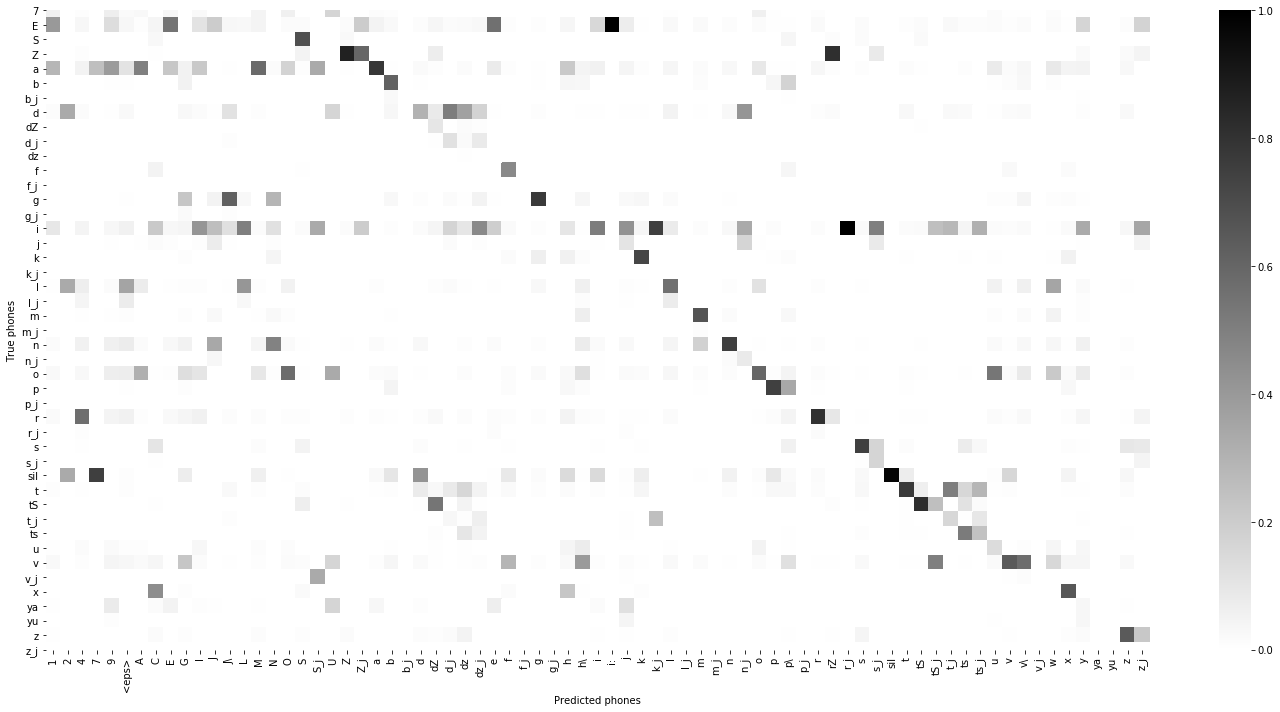

In [279]:
plot_conf_matrix("pred.txt", "lab.txt", "phones.txt")

In [86]:
with open("BG_text", "r") as f:
    lines = f.read().splitlines()


In [2]:
with open("ctm_39phn", "r") as f:
    lines = f.read().splitlines()

In [7]:
phones_list = [x.split()[4] for x in lines if x.startswith("BG")]

In [285]:
counted = get_true_phone_counts("BG_text")

In [31]:
def get_true_phone_counts(filename):
    full_list = []
    with open(filename, "r") as f:
        for line in f:
            full_list += line.split()[1:]
    true_phone_counts = Counter(full_list)     
    return true_phone_counts
    
    
def filter_preds(pred_arr):
    def _remove_single_preds(pred_arr):
        del_idx = []
        has_repeats = False
        prev_pred = pred_arr[0]
        for idx, pred in enumerate(pred_arr[1:]):
            # Part of consecutive duplicates e.g. [42, 42, ...]
            if pred == prev_pred:
                has_repeats = True
            else:
                # Check if was unique [39, 39, *42*, 21, 21] or repeated e.g. [39, 39, *42*, *42*, *42*, 21, 21]
                if has_repeats:
                    has_repeats = False
                else:
                    del_idx.append(idx)
                    #print("unique val found") # For debugging
                    #print(pred_list[idx-2:idx+3])
            prev_pred = pred
        return np.delete(pred_arr, del_idx)
    
    def _remove_consecutive_duplicates(pred_arr):
        return np.asarray([x[0] for x in groupby(pred_arr)])
    
    pred_no_dup = _remove_single_preds(pred_arr)
    pred_no_dup = _remove_consecutive_duplicates(pred_no_dup)
    return pred_no_dup


def normalise_counts(counter, return_percentage=False):
    norm_dict = {}
    total = 0
    for key, value in counter.items():
        # Skip the silence phones
        if key == "sil":
            continue
        else:
            norm_dict[key] = value
            total += value
    
    for key, value in norm_dict.items():
        norm_count = value/total
        if return_percentage:
            norm_count *= 100
        norm_dict[key] = norm_count
    
    return norm_dict


def convert_to_sorted_lists(dict_in):
    list_keys = list(dict_in.keys())
    list_values = list(dict_in.values())
    
    # Sort alphabetically 
    list_values = [y for x,y in sorted(zip(list_keys,list_values))]
    list_keys = sorted(list_keys)
    
    # Convert to arrays
    list_keys = np.asarray(list_keys)
    list_values = np.asarray(list_values)
    
    return list_keys, list_values


def plot_results(true_phones, true_vals, pred_vals, save_figs, figsize=(10,4)):
    def _save_plot(plt, name):
        plt.tight_layout()
        plt.savefig(name + ".pdf",bbox_inches="tight")
        
    N = len(pred_vals)
    
    ind = np.arange(N)
    width = 0.35
    
    # Plot single true
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(ind, true_vals, width*2, color="tab:blue")
    ax.set_xticks(ind)
    ax.set_xticklabels(true_phones)
    plt.xticks(rotation=90)
    plt.xlabel("Phone")
    plt.ylabel("Percentage of occurrences")
    if save_figs:
        _save_plot(plt, "true_phones")
    
    # Plot single pred
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(ind, pred_vals, width*2, color="tab:orange")
    ax.set_xticks(ind)
    ax.set_xticklabels(true_phones)
    plt.xticks(rotation=90)
    plt.xlabel("Phone")
    plt.ylabel("Percentage of occurrences")
    
    if save_figs:
        _save_plot(plt, "pred_phones")
    
    # Plot side by side
    fig, ax = plt.subplots(figsize=figsize)
    rects1 = ax.bar(ind, true_vals, width, label="True phones")
    
    rects2 = ax.bar(ind+width, pred_vals, width, label="Predicted phones")
    
    ax.set_ylabel("Percentage of language")
    ax.set_xticks(ind + width /2)
    ax.set_xticklabels(true_phones)
    plt.xticks(rotation=90)
    plt.xlabel("Phone")
    plt.ylabel("Percentage of occurrences")
    plt.legend()
    
    if save_figs:
        _save_plot(plt, "true_pred_phones")
    
    
    # Plot absolute differences
    fig, ax = plt.subplots(figsize=figsize)
    diff = true_vals - pred_vals
    ax.axhline(linewidth=0.5, color="black")
    plt.bar(ind, diff, width, color="tab:purple")
    
    ax.set_xticks(ind)
    ax.set_xticklabels(true_phones)
    plt.xticks(rotation=90)
    plt.xlabel("Phone")
    plt.ylabel("Absolute difference")
    
    if save_figs:
        _save_plot(plt, "diff")
    
    # Plot relative differences
    fig, ax = plt.subplots(figsize=figsize)
    rel_diff = (diff / (true_vals+1))*100
    
    print(true_phones)
    print(true_vals)
    print(pred_vals)
    print(diff)
    print(rel_diff)
    
    ax.axhline(linewidth=0.5, color="black")
    plt.bar(ind, rel_diff, width, color="tab:green")
    ax.set_xticks(ind)
    ax.set_xticklabels(true_phones)
    plt.xticks(rotation=90)
    ax.set_ylim((-105,105))
    plt.xlabel("Phone")
    plt.ylabel("Relative difference")
    
    if save_figs:
        _save_plot(plt, "rel_diff")
    
    return

In [15]:
pred_2_counts = Counter(phones_list)

In [19]:
count_j = [value  for key,value in true_phone_counts.items()if key.endswith("_j")]

In [23]:
sum(true_phone_counts.values())

116552

In [33]:
from dictances import bhattacharyya

ModuleNotFoundError: No module named 'dictances'

Normalising counts...
Sorting...
Plotting...
['7' 'E' 'S' 'Z' 'a' 'b' 'b_j' 'd' 'dZ' 'd_j' 'dz' 'f' 'f_j' 'g' 'g_j' 'i'
 'j' 'k' 'k_j' 'l' 'l_j' 'm' 'm_j' 'n' 'n_j' 'o' 'p' 'p_j' 'r' 'r_j' 's'
 's_j' 't' 'tS' 't_j' 'ts' 'u' 'v' 'v_j' 'x' 'ya' 'yu' 'z' 'z_j']
[1.42964899e+00 9.88299682e+00 9.77950076e-01 5.14849054e-01
 1.26423071e+01 1.38316347e+00 5.35022015e-02 3.59429544e+00
 2.45583876e-02 2.71896434e-02 3.50834108e-03 4.27140527e-01
 7.89376743e-03 1.30597997e+00 3.50834108e-03 9.74880278e+00
 3.92057116e-01 2.91104601e+00 4.38542635e-03 2.78649990e+00
 2.76281860e-01 2.14359640e+00 3.94688372e-02 7.10614486e+00
 1.30685705e-01 8.50509587e+00 3.02506710e+00 1.57875349e-02
 5.08270914e+00 1.34194046e-01 5.16866350e+00 2.80667286e-02
 8.92346554e+00 1.24546108e+00 6.92897363e-02 8.83224867e-01
 1.27703615e+00 4.07756942e+00 5.61334573e-02 4.21878015e-01
 1.05601067e+00 5.08709457e-02 2.15324434e+00 8.77085270e-03]
[0.15472239662750023, 6.892994887433851, 1.181720333662212, 0.3172930

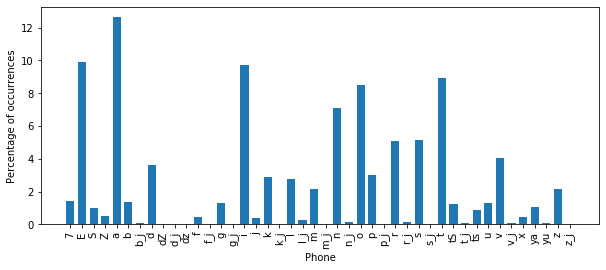

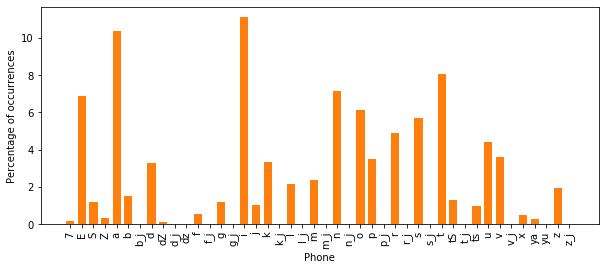

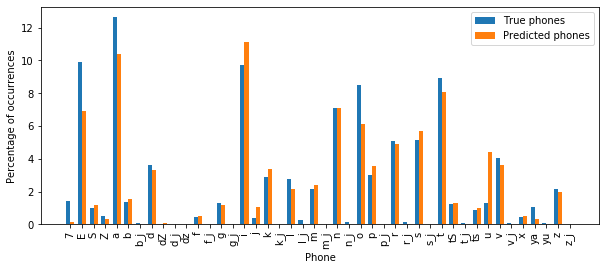

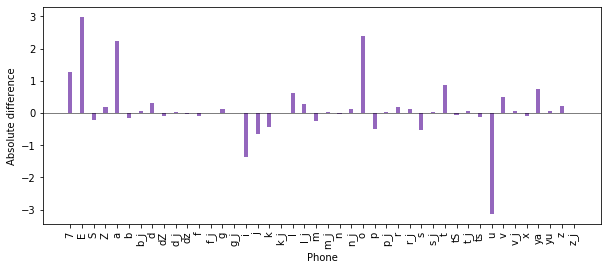

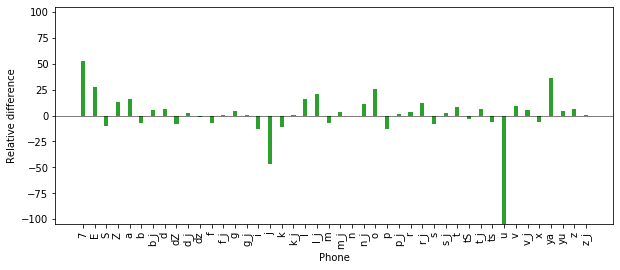

In [32]:
#pred_phone_counts = get_pred_phone_counts("pred.txt", "phones.txt")
#true_phone_counts = get_true_phone_counts("BG_text")
plot_phone_distributions(true_phone_counts, pred_2_counts, save_figs=False)

Normalising counts...
Sorting...
Plotting...


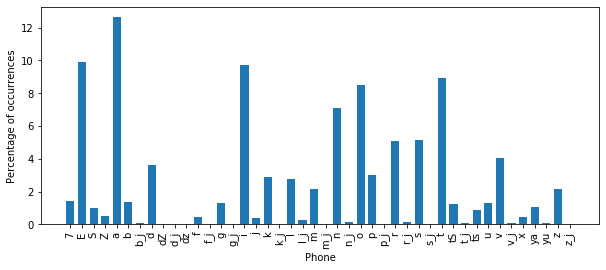

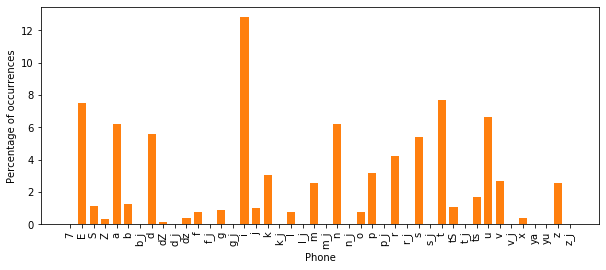

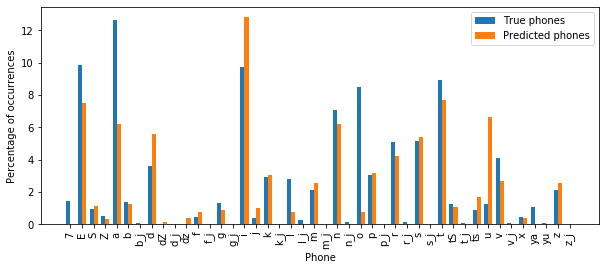

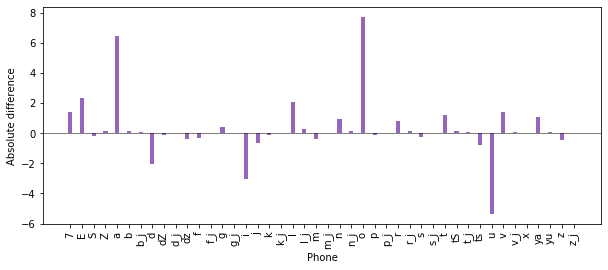

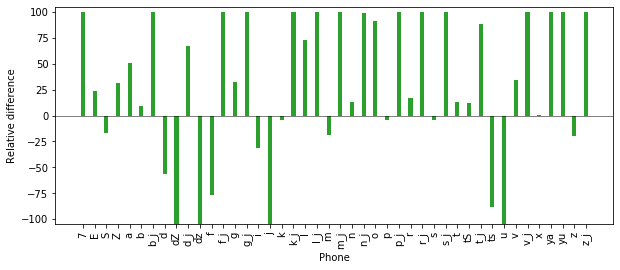

In [14]:
def get_pred_phone_counts(pred_file, phones_txt_filepath):
    pred = read_labels(pred_file)
    pred = filter_preds(pred)
    idx_to_phone = read_phones_txt(phones_txt_filepath)
    
    pred_phones = np.asarray([idx_to_phone[x] for x in pred])
    pred_phone_counts = Counter(pred_phones)
    return pred_phone_counts

def plot_phone_distributions(true_phone_counts, pred_phone_counts, save_figs=False):
    print("Normalising counts...")
    norm_true = normalise_counts(true_phone_counts, return_percentage=True)
    norm_pred = normalise_counts(pred_phone_counts, return_percentage=True)
    
    print("Sorting...")
    true_phones, true_vals = convert_to_sorted_lists(norm_true)
    pred_vals = [norm_pred[x] if x in norm_pred else 0 for x in true_phones]
    
    print("Plotting...")
    plot_results(true_phones, true_vals, pred_vals, save_figs)

pred_phone_counts = get_pred_phone_counts("pred.txt", "phones.txt")
true_phone_counts = get_true_phone_counts("BG_text")
plot_phone_distributions(true_phone_counts, pred_phone_counts, save_figs=False)

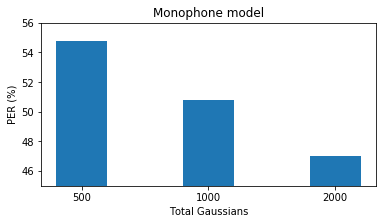

In [58]:
mono = [(500, 54.80), (1000, 50.79), (2000, 47.01)]
mono_vals = [x[1] for x in mono]
mono_keys = [str(x[0]) for x in mono]
plt.figure(figsize=(6, 3))
plt.ylim(45, 56)
plt.bar(mono_keys, mono_vals, width=0.4)
plt.xlabel("Total Gaussians")
plt.ylabel("PER (%)")
plt.title("Monophone model")
plt.savefig("mono.pdf", bbox_inches="tight")
plt.show()

In [80]:
import csv, re

def extract_vals(exp_line):
    pattern = re.compile(r'.*l\w*_(.*)_g\w*_(.*) %WER (\d*\.\d*) \[')
    m = pattern.match(exp_line)
    
    leaves = m.group(1)
    gauss = m.group(2)
    per = m.group(3)
    return leaves, gauss, per

def write_to_csv(exp_results, expname):
    header = ["leaves", "gauss", "per"]
    all_rows = []
    for line in exp_results:
        leaves, gauss, per = extract_vals(line)
        all_rows.append([leaves, gauss, per])
    csv_filename = expname + ".csv"
    with open(csv_filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header)
        writer.writerows(all_rows)   

In [83]:
with open("results_summary.txt", "r") as f:
    mono = []
    tri1 = []
    tri2 = []
    tri3 = []
    for line in f:
        if line.startswith("mono"):
            mono.append(line)
        elif line.startswith("tri1"):
            tri1.append(line)
        elif line.startswith("tri2"):
            tri2.append(line)
        elif line.startswith("tri3"):
            tri3.append(line)

write_to_csv(tri1, "tri1")
write_to_csv(tri2, "tri2")
write_to_csv(tri3, "tri3")

In [15]:
def plot_tri_exp(tri_exp, plt_title=None, save_fig=False):
    tri_df = pd.read_csv(tri_exp + ".csv")
    tri_df = tri_df.pivot(index="leaves", columns="gauss", values="per")
    sns.heatmap(tri_df, cmap="magma_r", annot=True,fmt='.2f')
    plt.xlabel("No. Gaussians")
    plt.ylabel("No. Leaves")
    if plt_title is not None:
        plt.title(plt_title)
    plt.tight_layout()  
    if save_fig:
        plt.savefig(tri_exp + ".pdf", bbox_inches="tight")
    plt.show()
    

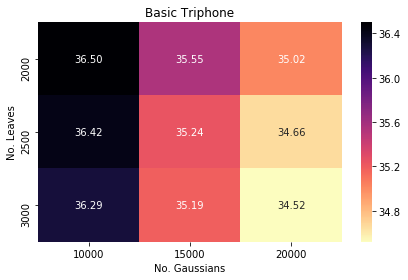

In [21]:
plot_tri_exp("tri1", plt_title="Basic Triphone", save_fig=True)

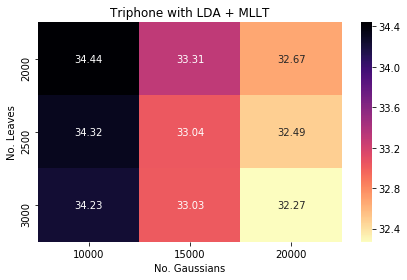

In [22]:
plot_tri_exp("tri2", plt_title="Triphone with LDA + MLLT", save_fig=True)

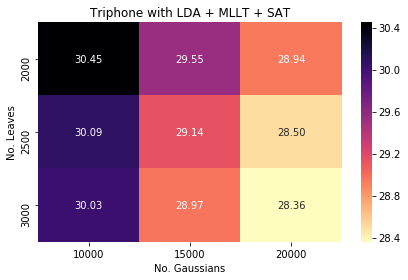

In [23]:
plot_tri_exp("tri3", plt_title="Triphone with LDA + MLLT + SAT", save_fig=True)